# Hardware efficiency

In [1]:
import csv
import re

miners = []
with open('miners.csv') as datafile:
    reader = csv.DictReader(datafile)
    for rowdict in reader:
        rowdict['Power (kW)'] = float(re.search('([0-9])+',rowdict['Power']).group(0))/1000.0
        rowdict['Hashrate (Th/s)'] = float(re.search('([0-9])+',rowdict['Hashrate']).group(0))
        rowdict['alpha (kWh/hash)']=rowdict['Power (kW)']/(rowdict['Hashrate (Th/s)']*3600)
        miners.append(rowdict)

Text(0, 0.5, 'kWh/hash')

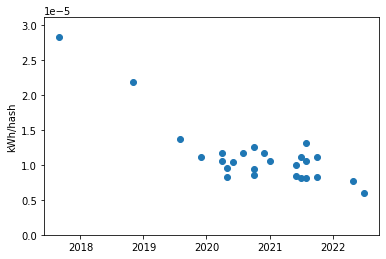

In [2]:
import matplotlib.pyplot as plt
import datetime as dt


plt.scatter(x=[dt.datetime.strptime(m['Date'], '%b %Y').date() for m in miners], 
         y=[m['alpha (kWh/hash)'] for m in miners])
plt.ylim([0,max(m['alpha (kWh/hash)'] for m in miners)*1.1])
plt.ylabel('kWh/hash')

# Mining share of value

In [3]:
import pandas as pd

In [4]:
rev = pd.read_csv('miners-revenue.csv')
mkt = pd.read_csv('market-cap.csv')
fees = pd.read_csv('transaction-fees-usd.csv')
rev.rename({'bbbbb﻿Timestamp': 'Timestamp'}, axis=1, inplace=True)
rev.set_index('Timestamp', inplace=True)
mkt.set_index('Timestamp', inplace=True)
fees.set_index('Timestamp', inplace=True)

df = mkt.merge(rev, how='outer', on='Timestamp', sort=True)
df = df.merge(fees, how='outer', on='Timestamp', sort=True)
df.index = pd.to_datetime(df.index)
df.interpolate(method='time', inplace=True)

In [5]:
vt = df.apply(lambda row: row['miners-revenue']*365.25/row['market-cap'], axis=1)
vtf = df.apply(lambda row: row['transaction-fees-usd']*365.25/row['market-cap'], axis=1)

/tmp/ipykernel_155987/3306131219.py:1: RuntimeWarning: invalid value encountered in double_scalars
  vt = df.apply(lambda row: row['miners-revenue']*365.25/row['market-cap'], axis=1)
/tmp/ipykernel_155987/3306131219.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  vt = df.apply(lambda row: row['miners-revenue']*365.25/row['market-cap'], axis=1)
/tmp/ipykernel_155987/3306131219.py:2: RuntimeWarning: invalid value encountered in double_scalars
  vtf = df.apply(lambda row: row['transaction-fees-usd']*365.25/row['market-cap'], axis=1)


Text(0.5, 1.0, 'annual_miner_rev/mkt_cap')

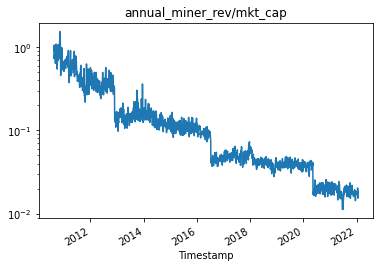

In [6]:
vt.plot()
plt.yscale('log')
plt.title('annual_miner_rev/mkt_cap')

Text(0.5, 1.0, 'annual_fees/mkt_cap')

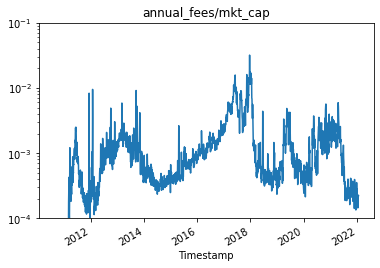

In [7]:
vtf.plot()
plt.yscale('log')
plt.ylim([1e-4,0.1])
plt.title('annual_fees/mkt_cap')